In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
    
aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [5]:
%%time
scenario = "Anaheim" #"Berlin-Center" #
num_iters = 5
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
bch.get_data_structure_with_by_directional_links()
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it


### Iterations
solutions_per_origin = {}
od_path_times = {}

for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        #t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        #t2 = time.time()
        #shortest_path_time += t2 - t1
    print(f"  {datetime.now()} - dijsktra done")
    
    for origin in origins:
        #t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        #t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        #t4 = time.time()
        solutions_per_origin[origin] = solution
        #opt_setup_time += t3 - t2
        #opt_solv_time += t4 - t3
    print(f"  {datetime.now()} - qp done")

    # so far nothing should have changed, right?
# the following needs to change though:
#     for origin in origins:
#         t4 = time.time()
#         t_assignment.update_path_flows(origin, solutions_per_origin[origin])
#         t5 = time.time()
#         update_time += t5 - t4
#     print(f"  {datetime.now()} - update done")

    for origin in origins:
        #t4 = time.time()
        # compute the new solution by assigning the path flows, but do not update the current solution yet
        t_assignment.update_path_flows_without_link_flows(origin, solutions_per_origin[origin])
        #t5 = time.time()
        #update_time += t5 - t4
    print(f"  {datetime.now()} - update done")

    # not parallel:
    # Find stepsize, for now set it to 0.4
    stepsize = 0.4
    print(f"  {datetime.now()} - Stepsize finding done: Fixing stepsize to {stepsize}")

    
    # update solution:
    # new solution of link flows = sum_{r in origin} (1-stepsize) old_solution_r + stepsize new_solution_r
    stepsize_time = 0.0
    for origin in origins:
        t_assignment.update_link_flows_stepsize(origin, stepsize)
    print(f"  {datetime.now()} - Taking step done")


    t_assignment.update_all_link_derivatives() # now by hand in python loop
    print(f"  {datetime.now()} - Updated derivatives")
    
 

    # TODO: update path flows.
    for origin in origins:
        # update path flows: new_path_flows = (1-stepsize) * old_path_flow + stepsize * new_path_flow
        t_assignment.update_path_flows_stepsize(origin, stepsize)
        # 
    print(f"  {datetime.now()} - blended path flows")


    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)

    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")

print(f"{datetime.now()} - Done")
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-05 07:51:28.528512 - Running scenario Anaheim
2020-12-05 07:51:28.539413 - num nodes = 416, num links = 914
2020-12-05 07:51:28.550622 - performing initial solution
  2020-12-05 07:51:28.581913 - starting iteration 0
  2020-12-05 07:51:28.593698 - dijsktra done
  2020-12-05 07:51:28.935322 - qp done
  2020-12-05 07:51:28.943408 - update done
  2020-12-05 07:51:28.943516 - Stepsize finding done: Fixing stepsize to 0.4


NameError: name 'alpha' is not defined

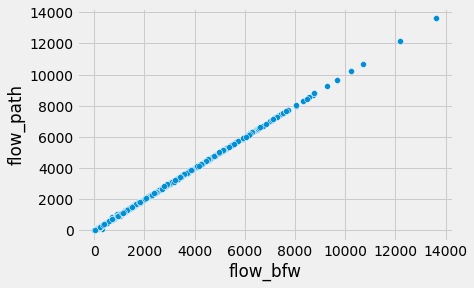

max diff in flow = 220.189842707502
max rel diff in flow = 54.574671507180206


,link_id,a_node,b_node,ff_time,capacity,direction,flow_bfw,flow_path,abs_change,rel_change
704,704,354,355,1.0,5400,1,304.546982,84.357140,220.189843,0.723008
758,758,370,371,1.0,5400,1,925.147365,1048.197998,123.050633,0.133007
760,760,371,355,2.0,5400,1,713.051139,836.097778,123.046640,0.172564
667,667,342,343,1.0,5400,1,650.530030,755.284058,104.754028,0.161029
756,756,370,354,2.0,5400,1,1121.615256,1022.513672,99.101585,0.088356
706,706,355,343,2.0,5400,1,1017.598121,920.454834,97.143287,0.095463
702,702,354,342,2.0,5400,1,988.982204,1071.859863,82.877659,0.083801
662,662,341,327,1.0,5400,1,1508.940940,1584.625488,75.684548,0.050157
610,610,328,327,1.0,5400,1,779.714005,704.932190,74.781815,0.095909
607,607,327,328,1.0,5400,1,870.071336,942.040222,71.968886,0.082716


CPU times: user 44.5 s, sys: 516 ms, total: 45 s
Wall time: 10.8 s


In [15]:
%%time
compare_flows = True
if compare_flows:
    bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)
    full_result = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
    sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
    plt.show();
    full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
    full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
    print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
    print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
    display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))